In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

# connection neon avec mon .env
load_dotenv()

url = URL.create(
    drivername="postgresql+psycopg2",
    username=os.getenv("NEON_USER"),
    password=os.getenv("NEON_PASSWORD"),
    host=os.getenv("NEON_HOST"),
    port=int(os.getenv("NEON_PORT", "5432")),
    database=os.getenv("NEON_DB"),
    query={"sslmode": os.getenv("NEON_SSLMODE", "require")},
)

engine = create_engine(url, pool_pre_ping=True)

pd.read_sql("select now() as now, version() as version;", engine)


,now,version
0,2025-12-16 13:34:22.822164+00:00,PostgreSQL 17.7 (bdc8956) on aarch64-unknown-l...


In [3]:
from sqlalchemy import text

with engine.connect() as conn:
    df_tables = pd.read_sql_query(text("""
        SELECT table_schema, table_name, table_type
        FROM information_schema.tables
        WHERE table_schema NOT IN ('pg_catalog','information_schema')
          AND (table_name LIKE 'dim_%%' OR table_name LIKE 'fact_%%')
        ORDER BY table_schema, table_name;
    """), conn)

df_tables


,table_schema,table_name,table_type
0,public,dim_country,BASE TABLE
1,public,dim_time,BASE TABLE
2,public,fact_energy_environment,BASE TABLE
3,public,fact_socio_economy,BASE TABLE


In [4]:
SCHEMA = "public"
FACT_TABLE = "fact_energy_environment"

with engine.connect() as conn:
    cols = pd.read_sql_query(text("""
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_schema = :s AND table_name = :t
        ORDER BY ordinal_position;
    """), conn, params={"s": SCHEMA, "t": FACT_TABLE})

cols


,column_name,data_type
0,country_key,bigint
1,year,integer
2,primary_energy_consumption,double precision
3,coal_consumption,double precision
4,oil_consumption,double precision
...,...,...
86,temperature_change_from_co2,double precision
87,greenhouse_gas_emissions,double precision
88,access_electricity_pct,double precision
89,access_clean_cooking_pct,double precision


In [5]:
with engine.connect() as conn:
    df_world = pd.read_sql_query(text("""
        SELECT
          f.year::int AS year,
          SUM(f.co2_emissions) AS co2_world,
          AVG(f.temperature_change_from_co2) AS temp_world_avg
        FROM public.fact_energy_environment f
        JOIN public.dim_country c
          ON c.country_key = f.country_key
        WHERE f.co2_emissions IS NOT NULL
          AND f.temperature_change_from_co2 IS NOT NULL
          AND c.iso_code NOT LIKE 'OWID_%'   -- évite double comptage (World/regions)
        GROUP BY 1
        ORDER BY 1;
    """), conn)

df_world.head(), df_world.tail()


(   year  co2_world  temp_world_avg
 0  1960   7742.122        0.003244
 1  1961   7693.731        0.003289
 2  1962   7939.456        0.003393
 3  1963   8337.110        0.003483
 4  1964   8759.297        0.003462,
     year  co2_world  temp_world_avg
 59  2019  35843.133        0.005252
 60  2020  34262.416        0.005320
 61  2021  36087.415        0.005413
 62  2022  36263.181        0.005510
 63  2023  36664.678        0.005592)

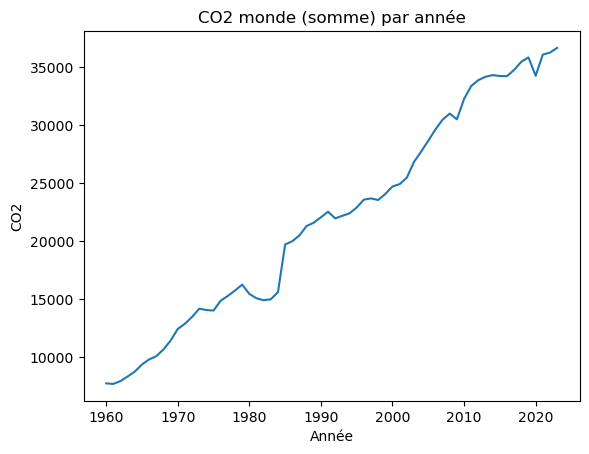

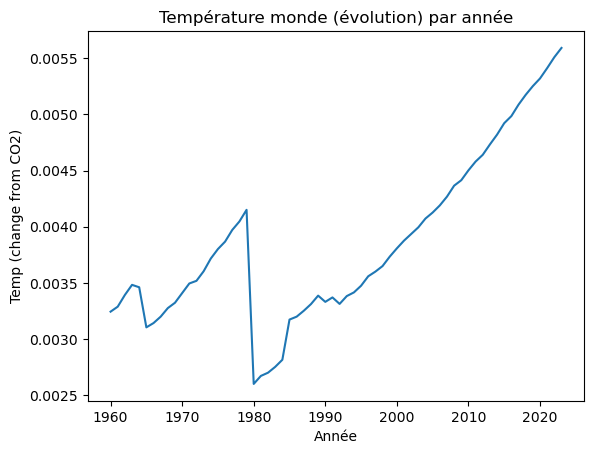

,year,co2_world,temp_world_avg,co2_yoy_pct,temp_yoy
59,2019,35843.133,0.005252,1.042453,0.000078
60,2020,34262.416,0.005320,-4.410097,0.000068
61,2021,36087.415,0.005413,5.326533,0.000092
62,2022,36263.181,0.005510,0.487056,0.000097
63,2023,36664.678,0.005592,1.107175,0.000083


In [6]:
import matplotlib.pyplot as plt

df = df_world.copy() 
df["co2_yoy_pct"] = df["co2_world"].pct_change() * 100
df["temp_yoy"] = df.iloc[:, df.columns.get_loc("temp_world_avg")].diff()  # diff annuelle

plt.figure()
plt.plot(df["year"], df["co2_world"])
plt.title("CO2 monde (somme) par année")
plt.xlabel("Année")
plt.ylabel("CO2")
plt.show()

plt.figure()
temp_col = "temp_world_avg" if "temp_world_avg" in df.columns else "temp_world_pop_weighted"
plt.plot(df["year"], df[temp_col])
plt.title("Température monde (évolution) par année")
plt.xlabel("Année")
plt.ylabel("Temp (change from CO2)")
plt.show()

df.tail()

ON VOIT QU'IL Y A UN PROBLEME EN 1980 --> ON VA FOUILLER POUR EXPLIQUER CELA

In [7]:
with engine.connect() as conn:
    qc = pd.read_sql_query(text("""
        SELECT
          f.year::int AS year,
          COUNT(*) AS n_rows,
          COUNT(DISTINCT f.country_key) AS n_countries,
          SUM(CASE WHEN f.temperature_change_from_co2 IS NULL THEN 1 ELSE 0 END) AS n_temp_null,
          SUM(CASE WHEN f.co2_emissions IS NULL THEN 1 ELSE 0 END) AS n_co2_null
        FROM public.fact_energy_environment f
        JOIN public.dim_country c ON c.country_key = f.country_key
        WHERE c.iso_code NOT LIKE 'OWID_%'
        GROUP BY 1
        ORDER BY 1;
    """), conn)

qc.head(), qc.tail()

## Couverture pays : 92 pays en 1960 à 220 pays 2020–2023 
## 2024 est inutilisable : n_temp_null = 123 et n_co2_null = 123 = toutes les lignes 2024 ont CO2/temp à NULL
## Exclure 2024 des analyses futures


(   year  n_rows  n_countries  n_temp_null  n_co2_null
 0  1960      92           92            0           2
 1  1961      92           92            0           2
 2  1962      92           92            0           3
 3  1963      92           92            0           3
 4  1964      92           92            0           1,
     year  n_rows  n_countries  n_temp_null  n_co2_null
 60  2020     220          220           14          14
 61  2021     220          220           14          14
 62  2022     220          220           14          14
 63  2023     220          220           14          14
 64  2024     123          123          123         123)

In [8]:
qc[(qc["year"] >= 1975) & (qc["year"] <= 1985)]


,year,n_rows,n_countries,n_temp_null,n_co2_null
15,1975,107,107,1,1
16,1976,107,107,1,1
17,1977,107,107,1,1
18,1978,107,107,1,1
19,1979,107,107,1,1
20,1980,193,193,14,20
21,1981,193,193,14,19
22,1982,193,193,14,19
23,1983,193,193,14,19
24,1984,193,193,14,19


In [9]:
qc = qc.copy()
qc["pct_temp_null"] = qc["n_temp_null"] / qc["n_rows"]
qc["pct_co2_null"]  = qc["n_co2_null"]  / qc["n_rows"]
qc[(qc["year"] >= 1975) & (qc["year"] <= 1985)][["year","n_countries","pct_temp_null","pct_co2_null"]]


,year,n_countries,pct_temp_null,pct_co2_null
15,1975,107,0.009346,0.009346
16,1976,107,0.009346,0.009346
17,1977,107,0.009346,0.009346
18,1978,107,0.009346,0.009346
19,1979,107,0.009346,0.009346
20,1980,193,0.072539,0.103627
21,1981,193,0.072539,0.098446
22,1982,193,0.072539,0.098446
23,1983,193,0.072539,0.098446
24,1984,193,0.072539,0.098446


In [10]:
## PAYS AJOUTÉS EN 1980 PAR RAPPORT À 1979

YEAR_PREV = 1979
YEAR_NEW  = 1980

with engine.connect() as conn:
    added = pd.read_sql_query(text("""
        WITH prev AS (
          SELECT DISTINCT f.country_key
          FROM public.fact_energy_environment f
          JOIN public.dim_country c ON c.country_key = f.country_key
          WHERE c.iso_code NOT LIKE 'OWID_%' AND f.year = :y_prev
        ),
        y0 AS (
          SELECT DISTINCT f.country_key
          FROM public.fact_energy_environment f
          JOIN public.dim_country c ON c.country_key = f.country_key
          WHERE c.iso_code NOT LIKE 'OWID_%' AND f.year = :y0
        )
        SELECT c.country_key, c.country_name, c.iso_code
        FROM y0
        JOIN public.dim_country c ON c.country_key = y0.country_key
        WHERE y0.country_key NOT IN (SELECT country_key FROM prev)
        ORDER BY c.country_name;
    """), conn, params={"y_prev": YEAR_PREV, "y0": YEAR_NEW})

added.head(100), len(added)


(    country_key                  country_name iso_code
 0             4                American Samoa      ASM
 1             6                    Antarctica      ATA
 2             7           Antigua and Barbuda      ATG
 3            14                       Bahamas      BHS
 4            20                        Belize      BLZ
 ..          ...                           ...      ...
 82          211  United States Virgin Islands      VIR
 83          212                       Uruguay      URY
 84          214                       Vanuatu      VUT
 85          217                Western Sahara      ESH
 86          218                         Yemen      YEM
 
 [87 rows x 3 columns],
 87)

In [11]:
YEAR_PREV = 1979
YEAR_NEW  = 1980

with engine.connect() as conn:
    impact_1980 = pd.read_sql_query(text("""
        WITH prev AS (
          SELECT DISTINCT f.country_key
          FROM public.fact_energy_environment f
          JOIN public.dim_country c ON c.country_key = f.country_key
          WHERE c.iso_code NOT LIKE 'OWID_%' AND f.year = :y_prev
        ),
        y0 AS (
          SELECT DISTINCT f.country_key
          FROM public.fact_energy_environment f
          JOIN public.dim_country c ON c.country_key = f.country_key
          WHERE c.iso_code NOT LIKE 'OWID_%' AND f.year = :y0
        ),
        added AS (
          SELECT country_key FROM y0
          EXCEPT
          SELECT country_key FROM prev
        )
        SELECT
          CAST(:y0 AS int) AS year,

          -- CO2 : poids des pays ajoutés dans le total 1980
          SUM(f.co2_emissions) FILTER (WHERE f.co2_emissions IS NOT NULL) AS co2_total,
          SUM(f.co2_emissions) FILTER (WHERE f.co2_emissions IS NOT NULL AND f.country_key IN (SELECT country_key FROM added)) AS co2_added,
          (
            SUM(f.co2_emissions) FILTER (WHERE f.co2_emissions IS NOT NULL AND f.country_key IN (SELECT country_key FROM added))
            / NULLIF(SUM(f.co2_emissions) FILTER (WHERE f.co2_emissions IS NOT NULL), 0)
          )::float AS co2_share_added,

          -- TEMP : "poids" dans ton AVG (chaque pays non-null pèse pareil)
          COUNT(*) FILTER (WHERE f.temperature_change_from_co2 IS NOT NULL) AS n_temp_total,
          COUNT(*) FILTER (WHERE f.temperature_change_from_co2 IS NOT NULL AND f.country_key IN (SELECT country_key FROM added)) AS n_temp_added,
          (
            COUNT(*) FILTER (WHERE f.temperature_change_from_co2 IS NOT NULL AND f.country_key IN (SELECT country_key FROM added))
            / NULLIF(COUNT(*) FILTER (WHERE f.temperature_change_from_co2 IS NOT NULL), 0)
          )::float AS temp_weight_in_avg_by_count,

          -- TEMP : est-ce que l'ajout "baisse" / "monte" la moyenne ?
          AVG(f.temperature_change_from_co2) FILTER (WHERE f.temperature_change_from_co2 IS NOT NULL) AS temp_avg_all,
          AVG(f.temperature_change_from_co2) FILTER (
              WHERE f.temperature_change_from_co2 IS NOT NULL
                AND f.country_key IN (SELECT country_key FROM prev)
          ) AS temp_avg_old_only,
          AVG(f.temperature_change_from_co2) FILTER (
              WHERE f.temperature_change_from_co2 IS NOT NULL
                AND f.country_key IN (SELECT country_key FROM added)
          ) AS temp_avg_added_only,
          (
            AVG(f.temperature_change_from_co2) FILTER (WHERE f.temperature_change_from_co2 IS NOT NULL)
            - AVG(f.temperature_change_from_co2) FILTER (
                WHERE f.temperature_change_from_co2 IS NOT NULL
                  AND f.country_key IN (SELECT country_key FROM prev)
            )
          )::float AS temp_shift_vs_old_only

        FROM public.fact_energy_environment f
        JOIN public.dim_country c ON c.country_key = f.country_key
        WHERE c.iso_code NOT LIKE 'OWID_%'
          AND f.year = :y0;
    """), conn, params={"y_prev": YEAR_PREV, "y0": YEAR_NEW})

impact_1980

## co2_share_added = poids des pays ajoutés en 1980 dans le total CO2 1980 --> très faible


,year,co2_total,co2_added,co2_share_added,n_temp_total,n_temp_added,temp_weight_in_avg_by_count,temp_avg_all,temp_avg_old_only,temp_avg_added_only,temp_shift_vs_old_only
0,1980,15451.404,87.533,0.005665,179,74,0.0,0.002514,0.004143,0.000203,-0.001629


In [12]:
pd.set_option("display.float_format", "{:.6f}".format)

impact_1980["temp_weight_exact"] = impact_1980["n_temp_added"] / impact_1980["n_temp_total"]
impact_1980[["n_temp_total","n_temp_added","temp_weight_exact","temp_avg_all","temp_avg_old_only","temp_avg_added_only","temp_shift_vs_old_only"]]

## temp_weight_exact = poids des pays ajoutés dans la moyenne par pays --> 41%
## temp_avg_added_only = moyenne temp en 1980 mais uniquement sur les pays ajoutés en 1980 --> trop basse on se doute qu'il y a des 0 bizzarres
## temp_shift_vs_old_only = on voit bien l'impact néghatif des pays ajoutés en 1980 sur la moyenne mondiale


,n_temp_total,n_temp_added,temp_weight_exact,temp_avg_all,temp_avg_old_only,temp_avg_added_only,temp_shift_vs_old_only
0,179,74,0.413408,0.002514,0.004143,0.000203,-0.001629


In [13]:
YEAR_PREV = 1979
YEAR_NEW = 1980

with engine.connect() as conn:
    dist = pd.read_sql_query(text("""
        WITH prev AS (
          SELECT DISTINCT f.country_key
          FROM public.fact_energy_environment f
          JOIN public.dim_country c ON c.country_key = f.country_key
          WHERE c.iso_code NOT LIKE 'OWID_%' AND f.year = :y_prev
        ),
        y0 AS (
          SELECT DISTINCT f.country_key
          FROM public.fact_energy_environment f
          JOIN public.dim_country c ON c.country_key = f.country_key
          WHERE c.iso_code NOT LIKE 'OWID_%' AND f.year = :y0
        ),
        added AS (
          SELECT country_key FROM y0
          EXCEPT
          SELECT country_key FROM prev
        ),
        data AS (
          SELECT
            CASE WHEN f.country_key IN (SELECT country_key FROM added) THEN 'added' ELSE 'old' END AS grp,
            f.temperature_change_from_co2 AS temp
          FROM public.fact_energy_environment f
          JOIN public.dim_country c ON c.country_key = f.country_key
          WHERE c.iso_code NOT LIKE 'OWID_%'
            AND f.year = :y0
            AND f.temperature_change_from_co2 IS NOT NULL
        )
        SELECT
          grp,
          COUNT(*) AS n,
          AVG(temp) AS avg_temp,
          MIN(temp) AS min_temp,
          MAX(temp) AS max_temp,
          SUM(CASE WHEN temp = 0 THEN 1 ELSE 0 END) AS n_zero
        FROM data
        GROUP BY 1
        ORDER BY 1;
    """), conn, params={"y_prev": YEAR_PREV, "y0": YEAR_NEW})

dist


,grp,n,avg_temp,min_temp,max_temp,n_zero
0,added,74,0.000203,0.000000,0.002000,60
1,old,105,0.004143,0.000000,0.138000,37


In [14]:
with engine.connect() as conn:
    lowest = pd.read_sql_query(text("""
        WITH prev AS (
          SELECT DISTINCT f.country_key
          FROM public.fact_energy_environment f
          JOIN public.dim_country c ON c.country_key = f.country_key
          WHERE c.iso_code NOT LIKE 'OWID_%' AND f.year = :y_prev
        ),
        y0 AS (
          SELECT DISTINCT f.country_key
          FROM public.fact_energy_environment f
          JOIN public.dim_country c ON c.country_key = f.country_key
          WHERE c.iso_code NOT LIKE 'OWID_%' AND f.year = :y0
        ),
        added AS (
          SELECT country_key FROM y0
          EXCEPT
          SELECT country_key FROM prev
        )
        SELECT
          c.country_name,
          c.iso_code,
          CASE WHEN f.country_key IN (SELECT country_key FROM added) THEN true ELSE false END AS is_added_1980,
          f.temperature_change_from_co2
        FROM public.fact_energy_environment f
        JOIN public.dim_country c ON c.country_key = f.country_key
        WHERE c.iso_code NOT LIKE 'OWID_%'
          AND f.year = :y0
          AND f.temperature_change_from_co2 IS NOT NULL
        ORDER BY f.temperature_change_from_co2 ASC
        LIMIT 30;
    """), conn, params={"y_prev": YEAR_PREV, "y0": YEAR_NEW})

lowest


,country_name,iso_code,is_added_1980,temperature_change_from_co2
0,Curacao,CUW,False,0.000000
1,El Salvador,SLV,True,0.000000
2,Cook Islands,COK,True,0.000000
3,Central African Republic,CAF,True,0.000000
4,Djibouti,DJI,True,0.000000
5,Egypt,EGY,False,0.000000
6,Albania,ALB,False,0.000000
7,Comoros,COM,True,0.000000
8,Antarctica,ATA,True,0.000000
9,Bahrain,BHR,False,0.000000


In [15]:
## Je decide de commencer en 1980 donc la je redefini mon dataset 

START_YEAR = 1980
END_YEAR = 2023

with engine.connect() as conn:
    df_world = pd.read_sql_query(text("""
        SELECT
          f.year::int AS year,
          SUM(f.co2_emissions) FILTER (WHERE f.co2_emissions IS NOT NULL) AS co2_world,
          AVG(NULLIF(f.temperature_change_from_co2, 0)) AS temp_world
        FROM public.fact_energy_environment f
        JOIN public.dim_country c ON c.country_key = f.country_key
        WHERE c.iso_code NOT LIKE 'OWID_%'
          AND f.year BETWEEN :start AND :end
        GROUP BY 1
        ORDER BY 1;
    """), conn, params={"start": START_YEAR, "end": END_YEAR})

df_world.head(), df_world.tail()


(   year    co2_world  temp_world
 0  1980 15451.404000    0.005488
 1  1981 15077.333000    0.005536
 2  1982 14909.622000    0.005465
 3  1983 14988.773000    0.005443
 4  1984 15604.664000    0.005568,
     year    co2_world  temp_world
 39  2019 35843.133000    0.008869
 40  2020 34262.416000    0.008984
 41  2021 36087.415000    0.008992
 42  2022 36263.181000    0.009080
 43  2023 36664.678000    0.009216)

In [16]:
df = df_world.dropna().copy()
df["ds"] = pd.to_datetime(df["year"].astype(str) + "-01-01")
df = df.sort_values("ds").set_index("ds")
df[["co2_world", "temp_world"]] = df[["co2_world", "temp_world"]].astype(float)

df.tail()


,year,co2_world,temp_world
ds,,,
2019-01-01,2019,35843.133000,0.008869
2020-01-01,2020,34262.416000,0.008984
2021-01-01,2021,36087.415000,0.008992
2022-01-01,2022,36263.181000,0.009080
2023-01-01,2023,36664.678000,0.009216


In [17]:
## PROJECTION 30 ANS 

import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

h = 30
future_index = pd.date_range(df.index.max() + pd.offsets.DateOffset(years=1), periods=h, freq="YS")

# CO2
y_co2 = df["co2_world"]
use_log = (y_co2 > 0).all()
y_co2_model = np.log(y_co2) if use_log else y_co2

m_co2 = SARIMAX(
    y_co2_model,
    order=(1,1,1),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

co2_fore = m_co2.get_forecast(steps=h)
co2_pred = co2_fore.predicted_mean
if use_log:
    co2_pred = np.exp(co2_pred)

# Temp 
m_temp = SARIMAX(
    df["temp_world"],
    exog=df[["co2_world"]],
    order=(1,1,1),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

exog_future = pd.DataFrame({"co2_world": co2_pred.values}, index=future_index)
temp_fore = m_temp.get_forecast(steps=h, exog=exog_future)
temp_pred = temp_fore.predicted_mean

proj = pd.DataFrame(index=future_index)
proj["co2_world_forecast"] = co2_pred.values
proj["temp_world_forecast"] = temp_pred.values

proj.head()


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle

,co2_world_forecast,temp_world_forecast
2024-01-01,37471.884332,0.009294
2025-01-01,38307.703240,0.009393
2026-01-01,39160.113273,0.009484
2027-01-01,40031.879172,0.009580
2028-01-01,40922.978466,0.009676


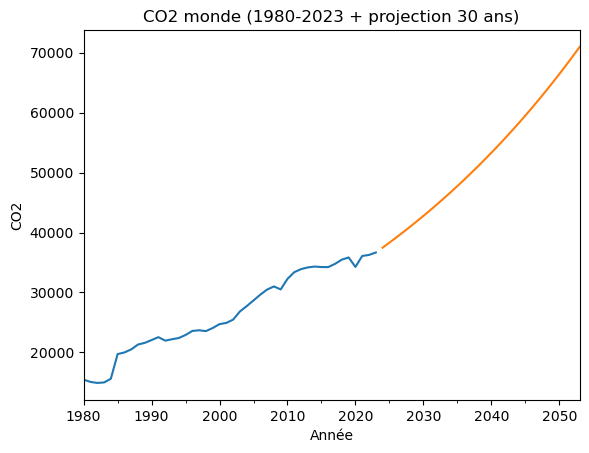

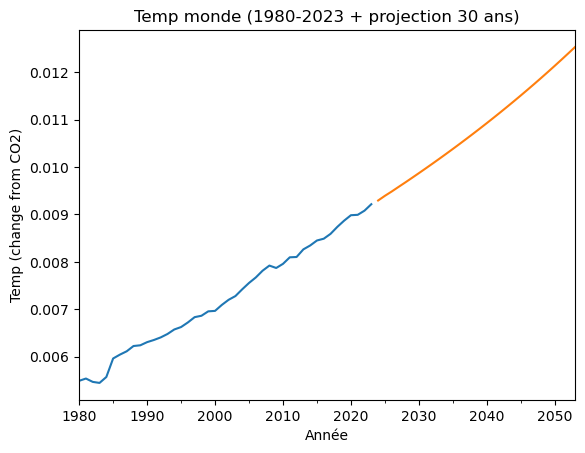

In [18]:
import matplotlib.pyplot as plt

plt.figure()
df["co2_world"].plot()
proj["co2_world_forecast"].plot()
plt.title("CO2 monde (1980-2023 + projection 30 ans)")
plt.xlabel("Année")
plt.ylabel("CO2")
plt.show()

plt.figure()
df["temp_world"].plot()
proj["temp_world_forecast"].plot()
plt.title("Temp monde (1980-2023 + projection 30 ans)")
plt.xlabel("Année")
plt.ylabel("Temp (change from CO2)")
plt.show()


maintenant que j'ai fais une projection en commencant en 1980 pour éviter toutes les valeurs nulles ajoutées en 1980, je vais faire la meme projection mais cette fois si en excluant tous les pays ajoutés en 1980 pour pouvoir prendre les années depuis 1960.

In [19]:
import pandas as pd
from sqlalchemy import text

START_YEAR = 1960
END_YEAR = 2023          # 2024 est vide
REF_YEAR = 1979          # année de référence pour garder les pays présents uniquement avant cette année

with engine.connect() as conn:
    df_world_1960 = pd.read_sql_query(text("""
        WITH ref_countries AS (
            SELECT DISTINCT f.country_key
            FROM public.fact_energy_environment f
            JOIN public.dim_country c ON c.country_key = f.country_key
            WHERE c.iso_code NOT LIKE 'OWID_%'
              AND f.year = :ref_year
        )
        SELECT
            f.year::int AS year,
            SUM(f.co2_emissions) FILTER (WHERE f.co2_emissions IS NOT NULL) AS co2_world,
            AVG(NULLIF(f.temperature_change_from_co2, 0)) AS temp_world
        FROM public.fact_energy_environment f
        JOIN public.dim_country c ON c.country_key = f.country_key
        WHERE c.iso_code NOT LIKE 'OWID_%'
          AND f.year BETWEEN :start_year AND :end_year
          AND f.country_key IN (SELECT country_key FROM ref_countries)
        GROUP BY 1
        ORDER BY 1;
    """), conn, params={"ref_year": REF_YEAR, "start_year": START_YEAR, "end_year": END_YEAR})

df_world_1960.head(), df_world_1960.tail()


(   year   co2_world  temp_world
 0  1960 7742.122000    0.005309
 1  1961 7693.731000    0.005382
 2  1962 7939.456000    0.005491
 3  1963 8337.110000    0.005636
 4  1964 8759.297000    0.005727,
     year    co2_world  temp_world
 59  2019 33068.418000    0.010522
 60  2020 31612.404000    0.010656
 61  2021 33320.997000    0.010833
 62  2022 33402.734000    0.010923
 63  2023 33784.949000    0.011088)

In [20]:
df = df_world_1960.dropna().copy()
df["ds"] = pd.to_datetime(df["year"].astype(str) + "-01-01")
df = df.sort_values("ds").set_index("ds").asfreq("YS")
df[["co2_world", "temp_world"]] = df[["co2_world", "temp_world"]].astype(float)

df.tail()


,year,co2_world,temp_world
ds,,,
2019-01-01,2019,33068.418000,0.010522
2020-01-01,2020,31612.404000,0.010656
2021-01-01,2021,33320.997000,0.010833
2022-01-01,2022,33402.734000,0.010923
2023-01-01,2023,33784.949000,0.011088


In [21]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

h = 30
future_index = pd.date_range(df.index.max() + pd.offsets.YearBegin(1), periods=h, freq="YS")

#CO2 
scale = 1000.0
y_co2 = (df["co2_world"] / scale).astype(float)

use_log = (y_co2 > 0).all()
y_co2_model = np.log(y_co2) if use_log else y_co2

m_co2 = SARIMAX(
    y_co2_model,
    order=(1,1,1),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

co2_fore = m_co2.get_forecast(steps=h)
co2_pred_scaled = co2_fore.predicted_mean

co2_pred = (np.exp(co2_pred_scaled) if use_log else co2_pred_scaled) * scale
co2_pred = pd.Series(co2_pred.values, index=future_index, name="co2_world_forecast")

# Temp 
m_temp = SARIMAX(
    df["temp_world"].astype(float),
    exog=df[["co2_world"]].astype(float),
    order=(1,1,1),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

exog_future = pd.DataFrame({"co2_world": co2_pred.values}, index=future_index)
temp_fore = m_temp.get_forecast(steps=h, exog=exog_future)
temp_pred = pd.Series(temp_fore.predicted_mean.values, index=future_index, name="temp_world_forecast")

proj = pd.concat([co2_pred, temp_pred], axis=1)
proj.head()


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,co2_world_forecast,temp_world_forecast
2024-01-01,34428.840854,0.011178
2025-01-01,35170.820559,0.011272
2026-01-01,35970.767520,0.011372
2027-01-01,36809.446426,0.011474
2028-01-01,37677.728794,0.011578


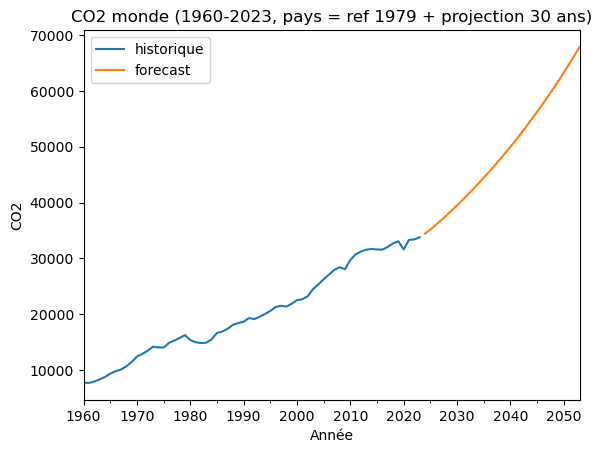

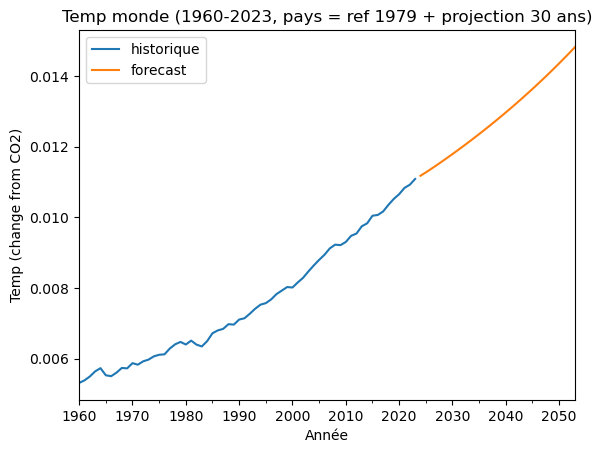

In [22]:
import matplotlib.pyplot as plt

plt.figure()
df["co2_world"].plot(label="historique")
proj["co2_world_forecast"].plot(label="forecast")
plt.title("CO2 monde (1960-2023, pays = ref 1979 + projection 30 ans)")
plt.xlabel("Année"); plt.ylabel("CO2")
plt.legend(); plt.show()

plt.figure()
df["temp_world"].plot(label="historique")
proj["temp_world_forecast"].plot(label="forecast")
plt.title("Temp monde (1960-2023, pays = ref 1979 + projection 30 ans)")
plt.xlabel("Année"); plt.ylabel("Temp (change from CO2)")
plt.legend(); plt.show()


MACHINE LEARNING 

In [23]:
##je selectionne les features pour le ML

import pandas as pd
from sqlalchemy import text

FEATURES_WANTED = [
    "primary_energy_consumption",
    "coal_consumption",
    "oil_consumption",
    "gas_consumption",
    "Nuclear_consumption",
    "hydro_consumption",
    "solar_consumption",
    "wind_consumption",
    "renewables_consumption",
    "fossil_fuel_consumption",
    "low_carbon_consumption",
]

SCHEMA = "public"
TABLE = "fact_energy_environment"

with engine.connect() as conn:
    cols = pd.read_sql_query(text("""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = :s AND table_name = :t
        ORDER BY ordinal_position;
    """), conn, params={"s": SCHEMA, "t": TABLE})

existing_cols = cols["column_name"].tolist()
lower_map = {c.lower(): c for c in existing_cols}

features_found = []
features_missing = []

for f in FEATURES_WANTED:
    hit = lower_map.get(f.lower())
    if hit:
        features_found.append(hit)  # nom exact en DB
    else:
        features_missing.append(f)

print("✅ Features trouvées :", features_found)
print("❌ Features manquantes :", features_missing)


✅ Features trouvées : ['primary_energy_consumption', 'coal_consumption', 'oil_consumption', 'gas_consumption', 'nuclear_consumption', 'hydro_consumption', 'solar_consumption', 'wind_consumption', 'renewables_consumption', 'fossil_fuel_consumption', 'low_carbon_consumption']
❌ Features manquantes : []


maintenant j'extrait mes données en prenant 1980 - 2023 (exlure avant 1980 et 2024) + je verifie les nulls 

In [24]:
START_YEAR = 1980
END_YEAR = 2023

select_features_sql = ",\n          ".join([f'f."{c}"' for c in features_found])

query = f"""
SELECT
  f.year::int AS year,
  f.country_key,
  f.co2_emissions,
  {select_features_sql}
FROM public.fact_energy_environment f
JOIN public.dim_country c
  ON c.country_key = f.country_key
WHERE c.iso_code NOT LIKE 'OWID_%'
  AND f.year BETWEEN :start AND :end
"""

with engine.connect() as conn:
    df = pd.read_sql_query(text(query), conn, params={"start": START_YEAR, "end": END_YEAR})

df.head()

null_summary = pd.DataFrame({
    "null_count": df[features_found].isna().sum(),
    "null_pct": df[features_found].isna().mean() * 100
}).sort_values("null_pct", ascending=False)

null_summary



,null_count,null_pct
coal_consumption,5995,63.837717
oil_consumption,5995,63.837717
gas_consumption,5995,63.837717
fossil_fuel_consumption,5995,63.837717
hydro_consumption,5995,63.837717
solar_consumption,5995,63.837717
wind_consumption,5995,63.837717
low_carbon_consumption,5995,63.837717
renewables_consumption,5995,63.837717
nuclear_consumption,4875,51.911405


In [25]:
## vu tous les nulls qu'il y a dans les features, je décide de faire une analyser des nulls sur toutes les features de la table fact

START_YEAR = 1960
END_YEAR = 2023

# liste des colonnes
with engine.connect() as conn:
    cols = pd.read_sql_query(text("""
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_schema = 'public'
          AND table_name = 'fact_energy_environment'
        ORDER BY ordinal_position;
    """), conn)

print("Nombre total de colonnes:", len(cols))

cols.head(91)


Nombre total de colonnes: 91


,column_name,data_type
0,country_key,bigint
1,year,integer
2,primary_energy_consumption,double precision
3,coal_consumption,double precision
4,oil_consumption,double precision
...,...,...
86,temperature_change_from_co2,double precision
87,greenhouse_gas_emissions,double precision
88,access_electricity_pct,double precision
89,access_clean_cooking_pct,double precision


In [26]:
## je calcule les nulls sur toutes les colonnes

START_YEAR = 1980
END_YEAR = 2023

exclude = {"country_key", "year"}  # on ne calcule pas le null% sur ces ids
table_cols = [c for c in cols["column_name"].tolist() if c not in exclude]

null_exprs = ",\n  ".join([
    f'COUNT(*) FILTER (WHERE f."{c}" IS NULL) AS "{c}"'
    for c in table_cols
])

sql = f"""
WITH base AS (
  SELECT f.*
  FROM public.fact_energy_environment f
  JOIN public.dim_country c ON c.country_key = f.country_key
  WHERE c.iso_code NOT LIKE 'OWID_%'
    AND f.year BETWEEN :start AND :end
)
SELECT
  COUNT(*) AS n_rows,
  {null_exprs}
FROM base f;
"""

with engine.connect() as conn:
    summary = pd.read_sql_query(text(sql), conn, params={"start": START_YEAR, "end": END_YEAR})

n_rows = int(summary.loc[0, "n_rows"])

nulls = summary.drop(columns=["n_rows"]).T.reset_index()
nulls.columns = ["column_name", "null_count"]
nulls["null_pct"] = nulls["null_count"] / n_rows * 100
nulls = nulls.sort_values("null_pct")


nulls.head(40), nulls.tail(40)


(                    column_name  null_count  null_pct
 0    primary_energy_consumption         105  1.118092
 50            energy_per_capita         162  1.725056
 84  temperature_change_from_co2         616  6.559472
 76                co2_emissions         667  7.102545
 77               co2_growth_abs         675  7.187733
 78              co2_growth_prct         690  7.347460
 83                      oil_co2         693  7.379406
 79               co2_per_capita         704  7.496539
 74          oil_prod_per_capita        1408 14.993078
 75          gas_prod_per_capita        1408 14.993078
 12               oil_production        1408 14.993078
 13               gas_production        1408 14.993078
 11              coal_production        1515 16.132467
 73         coal_prod_per_capita        1515 16.132467
 20          nuclear_electricity        2445 26.035566
 60      nuclear_elec_per_capita        2458 26.173996
 49               energy_per_gdp        2544 27.089767
 80       

1980+ tous pays vs supprimer les pays ajoutés --> la meilleure option est de garder tous les pays et de commencer en 1980, on aura plus de features a étudier pour le model

In [27]:
## j'ai trop de null 
## je commence en 1990 et je regarde les nulls à nouveau

In [28]:
START_YEAR = 1990
END_YEAR = 2020 

# toutes les colonnes de fact_energy_environment
with engine.connect() as conn:
    cols = pd.read_sql_query(text("""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'public'
          AND table_name = 'fact_energy_environment'
        ORDER BY ordinal_position;
    """), conn)

exclude = {"country_key", "year"}  # colonnes techniques
table_cols = [c for c in cols["column_name"].tolist() if c not in exclude]

#nb de NULL pour chaque colonne
null_exprs = ",\n  ".join([
    f'COUNT(*) FILTER (WHERE f."{c}" IS NULL) AS "{c}"'
    for c in table_cols
])

sql = f"""
WITH base AS (
  SELECT f.*
  FROM public.fact_energy_environment f
  JOIN public.dim_country c ON c.country_key = f.country_key
  WHERE c.iso_code NOT LIKE 'OWID_%'
    AND f.year BETWEEN :start AND :end
)
SELECT
  COUNT(*) AS n_rows,
  {null_exprs}
FROM base f;
"""

with engine.connect() as conn:
    summary = pd.read_sql_query(text(sql), conn, params={"start": START_YEAR, "end": END_YEAR})

n_rows = int(summary.loc[0, "n_rows"])

nulls_1980 = summary.drop(columns=["n_rows"]).T.reset_index()
nulls_1980.columns = ["column_name", "null_count"]
nulls_1980["null_pct"] = nulls_1980["null_count"] / n_rows * 100
nulls_1980 = nulls_1980.sort_values("null_pct")

nulls_1980.head(30), nulls_1980.tail(30)


(                    column_name  null_count  null_pct
 0    primary_energy_consumption          79  1.170891
 50            energy_per_capita         120  1.778568
 84  temperature_change_from_co2         434  6.432489
 76                co2_emissions         437  6.476953
 77               co2_growth_abs         443  6.565881
 83                      oil_co2         450  6.669631
 78              co2_growth_prct         455  6.743738
 79               co2_per_capita         468  6.936416
 12               oil_production         813 12.049800
 74          oil_prod_per_capita         813 12.049800
 75          gas_prod_per_capita         815 12.079443
 13               gas_production         815 12.079443
 11              coal_production         876 12.983548
 73         coal_prod_per_capita         876 12.983548
 20          nuclear_electricity        1305 19.341930
 60      nuclear_elec_per_capita        1315 19.490144
 24       renewables_electricity        1474 21.846747
 52       

In [29]:
## je regarde les 30 colonnes avec le moins de nulls

def features_under(threshold_pct: float):
    return nulls_1980[nulls_1980["null_pct"] <= threshold_pct]["column_name"].tolist()

features_5 = features_under(5.0)
features_10 = features_under(10.0)
features_20 = features_under(20.0)

print("<=5% NULL:", len(features_5))
print("<=10% NULL:", len(features_10))
print("<=20% NULL:", len(features_20))

nulls_1980.head(30)


<=5% NULL: 2
<=10% NULL: 8
<=20% NULL: 16


,column_name,null_count,null_pct
0,primary_energy_consumption,79,1.170891
50,energy_per_capita,120,1.778568
84,temperature_change_from_co2,434,6.432489
76,co2_emissions,437,6.476953
77,co2_growth_abs,443,6.565881
83,oil_co2,450,6.669631
78,co2_growth_prct,455,6.743738
79,co2_per_capita,468,6.936416
12,oil_production,813,12.049800
74,oil_prod_per_capita,813,12.049800


In [30]:
## je selectionne les features pour le ML

START_YEAR = 1990
END_YEAR = 2020

TARGET = "co2_emissions"
FEATURES = [
    "oil_production",
    "gas_production",
    "coal_production",
    "nuclear_electricity",
    "solar_electricity",
    "hydro_electricity",
    "wind_electricity",
]

cols_sql = ",\n  ".join([f'f."{c}"' for c in [TARGET] + FEATURES])

query = f"""
SELECT
  f.country_key,
  f.year::int AS year,
  {cols_sql}
FROM public.fact_energy_environment f
JOIN public.dim_country c ON c.country_key = f.country_key
WHERE c.iso_code NOT LIKE 'OWID_%'
  AND f.year BETWEEN :start AND :end
ORDER BY f.country_key, f.year;
"""

with engine.connect() as conn:
    df = pd.read_sql_query(text(query), conn, params={"start": START_YEAR, "end": END_YEAR})

# target obligatoire
df = df.dropna(subset=[TARGET]).copy()

df.head()


,country_key,year,co2_emissions,oil_production,gas_production,coal_production,nuclear_electricity,solar_electricity,hydro_electricity,wind_electricity
0,1,1990,2.024000,0.000000,31.940985,0.609598,NaN,NaN,NaN,NaN
1,1,1991,1.914000,0.000000,3.378293,0.545736,NaN,NaN,NaN,NaN
2,1,1992,1.482000,0.000000,3.253757,0.046446,NaN,NaN,NaN,NaN
3,1,1993,1.487000,0.000000,3.253757,0.040640,NaN,NaN,NaN,NaN
4,1,1994,1.454000,0.000000,3.252375,0.034834,NaN,NaN,NaN,NaN


In [37]:
## je fais une regrsession linéaire normale avec sklearn

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score,
)

FEATURES = [
    "oil_production","gas_production","coal_production",
    "nuclear_electricity","solar_electricity","hydro_electricity","wind_electricity"
]
TARGET = "co2_emissions"

# 1 = missing, 0 = present
for col in FEATURES:
    df[f"{col}_missing"] = df[col].isna().astype(int)

flag_cols = [f"{c}_missing" for c in FEATURES]
X_cols = FEATURES + flag_cols

TRAIN_END = 2015
train = df[df["year"] <= TRAIN_END].dropna(subset=[TARGET]).copy()
test  = df[df["year"] >  TRAIN_END].dropna(subset=[TARGET]).copy()

X_train, y_train = train[X_cols], train[TARGET]
X_test,  y_test  = test[X_cols],  test[TARGET]

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]), FEATURES),
    ("flags", "passthrough", flag_cols),
])

baseline_lr = Pipeline([
    ("prep", preprocess),
    ("lr", LinearRegression())
])

baseline_lr.fit(X_train, y_train)
pred_lr = baseline_lr.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, pred_lr)
mse = mean_squared_error(y_test, pred_lr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_lr)
evs = explained_variance_score(y_test, pred_lr)

eps = 1e-9
y_true = y_test.to_numpy()
mape = np.mean(np.abs((y_true - pred_lr) / np.maximum(np.abs(y_true), eps))) * 100

print("=== Baseline LinearRegression ===")
print("MAE :", mae)
print("RMSE:", rmse)
print("MSE :", mse)
print("R2  :", r2)
print("Explained variance:", evs)
print("MAPE (%):", mape)

# Coefficients (top 15)
feature_names = baseline_lr.named_steps["prep"].get_feature_names_out()
coefs = baseline_lr.named_steps["lr"].coef_

coef_df = (pd.DataFrame({"feature": feature_names, "coef": coefs})
             .assign(abs_coef=lambda d: d["coef"].abs())
             .sort_values("abs_coef", ascending=False))

display(coef_df.head(15))


=== Baseline LinearRegression ===
MAE : 69.71714955908469
RMSE: 233.9889581151671
MSE : 54750.832519821415
R2  : 0.9212370783568044
Explained variance: 0.922840190929684
MAPE (%): 1796698558.3525565


,feature,coef,abs_coef
2,num__coal_production,434.691252,434.691252
3,num__nuclear_electricity,170.610855,170.610855
8,flags__gas_production_missing,-94.177785,94.177785
7,flags__oil_production_missing,58.208317,58.208317
9,flags__coal_production_missing,-51.583130,51.583130
1,num__gas_production,48.664856,48.664856
0,num__oil_production,42.601704,42.601704
10,flags__nuclear_electricity_missing,-40.302912,40.302912
5,num__hydro_electricity,26.497421,26.497421
4,num__solar_electricity,20.038878,20.038878


In [42]:
## je regarde si les flags d'indication de nulls ont de l'importance dans le modèle

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

FEATURES = [
    "oil_production","gas_production","coal_production",
    "nuclear_electricity","solar_electricity","hydro_electricity","wind_electricity"
]
TARGET = "co2_emissions"

# 1 = missing, 0 = present
for col in FEATURES:
    df[f"{col}_missing"] = df[col].isna().astype(int)

flag_cols = [f"{c}_missing" for c in FEATURES]
X_cols_with_flags = FEATURES + flag_cols
X_cols_no_flags = FEATURES

TRAIN_END = 2015
train = df[df["year"] <= TRAIN_END].dropna(subset=[TARGET]).copy()
test  = df[df["year"] >  TRAIN_END].dropna(subset=[TARGET]).copy()

X_train_w, y_train = train[X_cols_with_flags], train[TARGET]
X_test_w,  y_test  = test[X_cols_with_flags],  test[TARGET]

X_train_n = train[X_cols_no_flags]
X_test_n  = test[X_cols_no_flags]

def evaluate(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    print(f"\n=== {name} ===")
    print("MAE :", mean_absolute_error(yte, pred))
    print("RMSE:", root_mean_squared_error(yte, pred))
    print("R2  :", r2_score(yte, pred))

# --- Baseline WITH flags ---
preprocess_with_flags = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),   # <-- gère les NaN
        ("scaler", StandardScaler()),
    ]), FEATURES),
    ("flags", "passthrough", flag_cols),
])

baseline_with_flags = Pipeline([
    ("prep", preprocess_with_flags),
    ("lr", LinearRegression())
])

# --- Baseline NO flags ---
preprocess_no_flags = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),   # <-- gère les NaN
        ("scaler", StandardScaler()),
    ]), FEATURES),
])

baseline_no_flags = Pipeline([
    ("prep", preprocess_no_flags),
    ("lr", LinearRegression())
])

evaluate("Baseline WITH flags", baseline_with_flags, X_train_w, y_train, X_test_w, y_test)
evaluate("Baseline NO flags",  baseline_no_flags,  X_train_n, y_train, X_test_n, y_test)



=== Baseline WITH flags ===
MAE : 69.71714955908469
RMSE: 233.9889581151671
R2  : 0.9212370783568044

=== Baseline NO flags ===
MAE : 108.02736349173209
RMSE: 242.6772385784625
R2  : 0.9152793694939563


--> l'ajout des flags missing améliore la précision
Sans flags, le modèle “subit” les valeurs manquantes (même imputées à la moyenne), et perd en precision

--> Les flags améliorent les métriques parce que la donnée manquante est informative (missing-not-at-random).

je decide d'utiliser random forest car robuste + (Lasso) + ElasticNet car moins penalisant et identifie les coef negatifs + regression normale (servir de valeur etalon)
MAPE = moyenne abs d'erreur en % entre les valeurs predites et les valeurs moyennes 

ls colonnes avec des valeurs nulles --> Je créé de nouvelles colonnes qui sont des bolleans 0/1 pour donner au model une domension supplémentaire 
0 = valeur presente
1 = valeur manquante 

permet de ne pas utiliser les NAN a mauvais escient 

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score

FEATURES = [
    "oil_production","gas_production","coal_production",
    "nuclear_electricity","solar_electricity","hydro_electricity","wind_electricity"
]
TARGET = "co2_emissions"

# 1 = missing, 0 = present
for col in FEATURES:
    df[f"{col}_missing"] = df[col].isna().astype(int)

flag_cols = [f"{c}_missing" for c in FEATURES]
X_cols = FEATURES + flag_cols

TRAIN_END = 2015
train = df[df["year"] <= TRAIN_END].dropna(subset=[TARGET]).copy()
test  = df[df["year"] >  TRAIN_END].dropna(subset=[TARGET]).copy()

X_train, y_train = train[X_cols], train[TARGET]
X_test,  y_test  = test[X_cols],  test[TARGET]

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),  # remplace NaN par 0
        ("scaler", StandardScaler()),
    ]), FEATURES),
    ("flags", "passthrough", flag_cols),
])

model = Pipeline([
    ("prep", preprocess),
    ("enet", ElasticNetCV(
        l1_ratio=[0.2, 0.5, 0.8, 1.0],
        cv=5,
        random_state=42,
        max_iter=20000
    ))
])

model.fit(X_train, y_train)
pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("R2 :", r2_score(y_test, pred))


MAE: 61.53975709963996
R2 : 0.9485820382289245


R² = 0.95 --> approche “valeur + flag présence” top

In [32]:
for f in FEATURES:
    m = train[f].isna()
    print(f, "missing_rate=", m.mean(),
          "mean_CO2_missing=", train.loc[m, TARGET].mean(),
          "mean_CO2_present=", train.loc[~m, TARGET].mean())


oil_production missing_rate= 0.024053030303030302 mean_CO2_missing= 21.05826771653543 mean_CO2_present= 137.49639821463225
gas_production missing_rate= 0.023674242424242424 mean_CO2_missing= 10.681991999999997 mean_CO2_present= 137.70283045586808
coal_production missing_rate= 0.023863636363636365 mean_CO2_missing= 8.26622222222222 mean_CO2_present= 137.7865339542103
nuclear_electricity missing_rate= 0.19715909090909092 mean_CO2_missing= 3.02321325648415 mean_CO2_present= 167.03141660769052
solar_electricity missing_rate= 0.23882575757575758 mean_CO2_missing= 4.766510705789056 mean_CO2_present= 175.46224682756906
hydro_electricity missing_rate= 0.23825757575757575 mean_CO2_missing= 4.745176470588236 mean_CO2_present= 175.34159820984587
wind_electricity missing_rate= 0.24696969696969698 mean_CO2_missing= 5.2421549079754595 mean_CO2_present= 177.15230633802818


missing_rate = 0.024 → 2,4% des lignes train ont oil_production manquant.

mean_CO2_missing = 21.06 → quand oil_production est manquant, la moyenne de co2_emissions est ~21

mean_CO2_present = 137.50 → quand oil_production est présent, la moyenne de co2_emissions est ~137

In [36]:
## JE TESTE EN IMPUTANT LES NULLS À LA MOYENNE DE LA FEATURE plutot que 0

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import (
    mean_absolute_error, r2_score,
    mean_squared_error, explained_variance_score
)

FEATURES = [
    "oil_production","gas_production","coal_production",
    "nuclear_electricity","solar_electricity","hydro_electricity","wind_electricity"
]
TARGET = "co2_emissions"

# 1 = missing, 0 = present
for col in FEATURES:
    df[f"{col}_missing"] = df[col].isna().astype(int)

flag_cols = [f"{c}_missing" for c in FEATURES]
X_cols = FEATURES + flag_cols

TRAIN_END = 2015
train = df[df["year"] <= TRAIN_END].dropna(subset=[TARGET]).copy()
test  = df[df["year"] >  TRAIN_END].dropna(subset=[TARGET]).copy()

X_train, y_train = train[X_cols], train[TARGET]
X_test,  y_test  = test[X_cols],  test[TARGET]

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]), FEATURES),
    ("flags", "passthrough", flag_cols),
])

model = Pipeline([
    ("prep", preprocess),
    ("enet", ElasticNetCV(l1_ratio=[0.2,0.5,0.8,1.0], cv=5, random_state=42, max_iter=20000))
])

model.fit(X_train, y_train)
pred = model.predict(X_test)

#variance / covariance + RMSE

resid = y_test - pred
y_true = y_test.to_numpy() #pour calculer MAPE
y_pred = pred #pour calculer MAPE

mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, pred)
evs  = explained_variance_score(y_test, pred)            # variance expliquée (proche de R², mais utile)
eps = 1e-9  # évite division par zéro
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

var_y     = np.var(y_test, ddof=0)
var_resid = np.var(resid, ddof=0)
std_resid = np.std(resid, ddof=0)
bias      = np.mean(resid)

cov_y_pred      = np.cov(y_test, pred, ddof=0)[0, 1]
corr_y_pred     = np.corrcoef(y_test, pred)[0, 1]
cov_resid_pred  = np.cov(resid, pred, ddof=0)[0, 1]
corr_resid_pred = np.corrcoef(resid, pred)[0, 1]

print("MAE :", mae)
print("MAPE (%):", mape)
print("RMSE:", rmse)
print("MSE :", mse)
print("R2  :", r2)
print("Explained variance:", evs)

print("\n--- Variance / Résidus ---")
print("Var(y_true)      :", var_y)
print("Var(residuals)   :", var_resid)
print("Std(residuals)   :", std_resid)
print("Bias (mean resid):", bias)
print("Var resid / Var y:", var_resid / var_y)

print("\n--- Covariance / Corrélation ---")
print("Cov(y_true, y_pred)     :", cov_y_pred)
print("Corr(y_true, y_pred)    :", corr_y_pred)
print("Cov(residuals, y_pred)  :", cov_resid_pred)
print("Corr(residuals, y_pred) :", corr_resid_pred)

print("\n--- ElasticNet params ---")
print("alpha   :", model.named_steps["enet"].alpha_)
print("l1_ratio:", model.named_steps["enet"].l1_ratio_)


MAE : 104.23962484784386
MAPE (%): 59253918571.94578
RMSE: 204.85005201478208
MSE : 41963.54381045893
R2  : 0.9396324921302811
Explained variance: 0.9470516570221753

--- Variance / Résidus ---
Var(y_true)      : 695134.6062027573
Var(residuals)   : 36806.225544978726
Std(residuals)   : 191.84948669459277
Bias (mean resid): -71.81447114252258
Var resid / Var y: 0.05294834297782473

--- Covariance / Corrélation ---
Cov(y_true, y_pred)     : 765100.5267927923
Corr(y_true, y_pred)    : 0.9827827232342012
Cov(residuals, y_pred)  : -106772.1461350136
Corr(residuals, y_pred) : -0.5960336754427783

--- ElasticNet params ---
alpha   : 7.434681340555951
l1_ratio: 1.0


R² ≈ 0.94 : le modèle explique encore très bien la variance.

MAE passe de ~61 → ~104 : normal, parce qu’avant, remplacer NaN par 0 donnait au modèle un “signal caché” très fort (0 ressemble énormément à petit pays / faible CO2). En imputant la moyenne, pas de signal artificiel, le modèle est forcé de s’appuyer sur les flags missing (ce qui est plus “propre” scientifiquement).

MSE = 41 963.54 → Même idée que MAE, mais les grosses erreurs sont beaucoup plus pénalisées car on met au carré

RMSE = 204.85 → “Erreur typique” en donnant plus de poids aux grosses erreurs = une erreur “typique” est ~205 (plus grand que MAE ⇒ tu as quelques grosses erreurs)

Qualité globale du modèle

R² = 0.9396 → le model explique environ 94% de la variation du CO₂ sur le jeu de test

Explained variance = 0.9471 → Très proche de R² : ça dit aussi que le modèle capture ~95% de la variabilité.
(Quand R² et explained variance sont proches, c’est cohérent.)

Variance / Résidus (comment “se répartissent” les erreurs)

Var(y_true) = 695 134.61 → Le CO₂ réel varie énormément dans les données (grosse dispersion).

Var(residuals) = 36 806.23 → La dispersion de tes erreurs : plus c’est petit vs Var(y_true), mieux c’est.

Std(residuals) = 191.85 → L’écart-type des erreurs (un peu comme “erreur typique”), proche du RMSE.

Bias (mean resid) = -71.81 → Tes résidus = (vrai - prédit). Négatif ⇒ tu surestimes en moyenne le CO₂ d’environ 72.
(Très important : ton modèle a un biais systématique.)

Var resid / Var y = 0.052 → Les erreurs représentent environ 5.3% de la variance du signal.
(Donc ~94.7% expliqué → cohérent avec R²/Explained variance.)

Covariance / Corrélation (est-ce que ça bouge ensemble)

Cov(y_true, y_pred) = 765 100.5 → Mesure brute “ils varient ensemble” (pas super interprétable seule).

Corr(y_true, y_pred) = 0.9828 → Corrélation très forte : quand le CO₂ réel augmente, la prédiction augmente aussi.
(Très bon signe.)

Cov(residuals, y_pred) = -106 772.15

Corr(residuals, y_pred) = -0.5960
→ Tes erreurs sont corrélées aux prédictions : quand le modèle prédit des valeurs élevées, il a tendance à sur-prédire (puisque résidu = vrai - prédit devient plus négatif).
(Ça indique un biais qui dépend du niveau : pas juste du bruit aléatoire.)

Paramètres ElasticNet

alpha = 7.4347
→ Intensité de la régularisation : plus c’est grand, plus le modèle “simplifie” / évite l’overfit.

l1_ratio = 1.0
→ Ça veut dire que ton ElasticNet a choisi 100% Lasso (pas de Ridge).
Conséquence : il peut mettre certains coefficients à 0 (faire de la sélection de variables).

,feature,coef,abs_coef
2,num__coal_production,433.667475,433.667475
3,num__nuclear_electricity,166.323292,166.323292
1,num__gas_production,49.382960,49.382960
0,num__oil_production,40.843799,40.843799
5,num__hydro_electricity,23.374435,23.374435
4,num__solar_electricity,14.258200,14.258200
11,flags__solar_electricity_missing,-11.783670,11.783670
6,num__wind_electricity,6.519060,6.519060
13,flags__wind_electricity_missing,-4.864682,4.864682


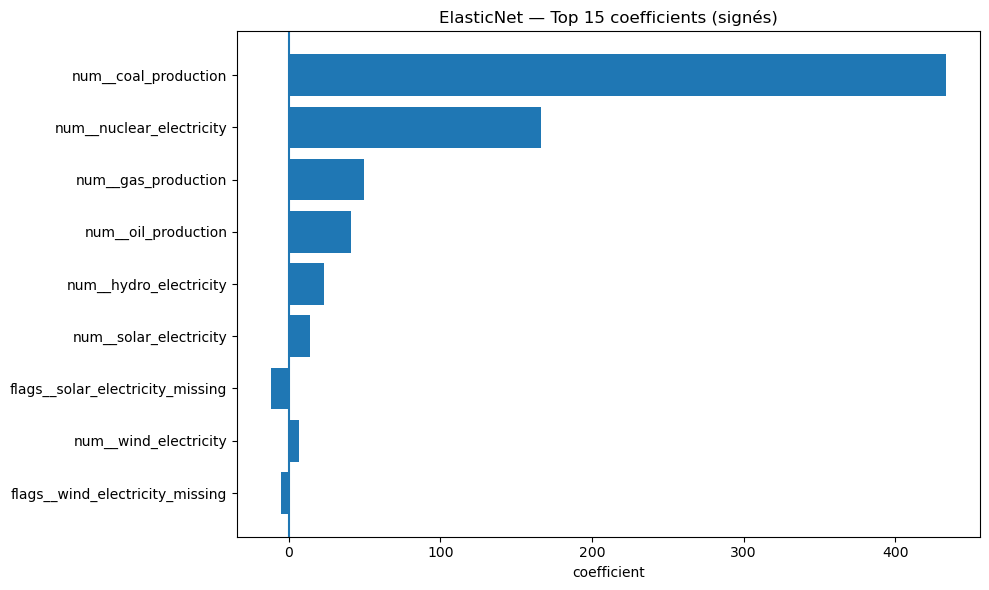

In [ ]:
# Récupérer les noms de features après preprocessing
prep = model.named_steps["prep"]               # ColumnTransformer
feat_names = prep.get_feature_names_out()

# Récupérer les coefficients ElasticNet
enet = model.named_steps["enet"]
coefs = enet.coef_

coef_df = pd.DataFrame({
    "feature": feat_names,
    "coef": coefs,
})
coef_df["abs_coef"] = coef_df["coef"].abs()

# enlever les coefs à 0 (sélection par ElasticNet)
coef_df_nz = coef_df[coef_df["coef"] != 0].sort_values("abs_coef", ascending=False)

display(coef_df_nz.head(30))

# 3) Plot des 15 features les plus influentes (en valeur absolue)
TOP = 15
top = coef_df_nz.head(TOP).sort_values("abs_coef")

plt.figure(figsize=(10, 6))
plt.barh(top["feature"], top["coef"])
plt.axvline(0)
plt.title(f"ElasticNet — Top {TOP} coefficients (signés)")
plt.xlabel("coefficient")
plt.tight_layout()
plt.show()


In [ ]:
#récupérer les noms de features après le ColumnTransformer
feat_names = model.named_steps["prep"].get_feature_names_out()

#récupérer les coeffs ElasticNet
coefs = model.named_steps["enet"].coef_

coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()

#voir uniquement les flags
flags_df = coef_df[coef_df["feature"].str.startswith("flags__")].sort_values("abs_coef", ascending=False)
print(flags_df)



                               feature       coef  abs_coef
11    flags__solar_electricity_missing -11.783670 11.783670
13     flags__wind_electricity_missing  -4.864682  4.864682
7        flags__oil_production_missing  -0.000000  0.000000
9       flags__coal_production_missing  -0.000000  0.000000
8        flags__gas_production_missing  -0.000000  0.000000
10  flags__nuclear_electricity_missing  -0.000000  0.000000
12    flags__hydro_electricity_missing  -0.000000  0.000000


En régression simple, les flags ‘missing’ peuvent prendre un poids important car le modèle utilise toute information disponible sans contrainte. 
Avec ElasticNet (ici proche Lasso --> l1_ratio = 1.0 --> fait de la sélection de variables : il peut mettre plein de coefficients exactement à 0 et ejecter des feature), une pénalisation sélectionne uniquement les variables qui améliorent vraiment la performance hors-échantillon : si l’effet ‘missing’ est redondant avec d’autres features, ses coefficients sont réduits voire annulés

In [ ]:
for f in FEATURES:
    m = train[f].isna()
    print(f, "missing_rate=", m.mean(),
          "mean_CO2_missing=", train.loc[m, TARGET].mean(),
          "mean_CO2_present=", train.loc[~m, TARGET].mean())


oil_production missing_rate= 0.024053030303030302 mean_CO2_missing= 21.05826771653543 mean_CO2_present= 137.49639821463225
gas_production missing_rate= 0.023674242424242424 mean_CO2_missing= 10.681991999999997 mean_CO2_present= 137.70283045586808
coal_production missing_rate= 0.023863636363636365 mean_CO2_missing= 8.26622222222222 mean_CO2_present= 137.7865339542103
nuclear_electricity missing_rate= 0.19715909090909092 mean_CO2_missing= 3.02321325648415 mean_CO2_present= 167.03141660769052
solar_electricity missing_rate= 0.23882575757575758 mean_CO2_missing= 4.766510705789056 mean_CO2_present= 175.46224682756906
hydro_electricity missing_rate= 0.23825757575757575 mean_CO2_missing= 4.745176470588236 mean_CO2_present= 175.34159820984587
wind_electricity missing_rate= 0.24696969696969698 mean_CO2_missing= 5.2421549079754595 mean_CO2_present= 177.15230633802818


In [ ]:
# noms des features après preprocessing
feat_out = model.named_steps["prep"].get_feature_names_out()

coefs = model.named_steps["enet"].coef_
coef_df = pd.DataFrame({"feature": feat_out, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()

# séparer num vs flags
coef_num = coef_df[coef_df["feature"].str.startswith("num__")].copy()
coef_flags = coef_df[coef_df["feature"].str.startswith("flags__")].copy()

coef_num = coef_num.sort_values("abs_coef", ascending=False)
coef_flags = coef_flags.sort_values("abs_coef", ascending=False)

coef_num.head(20), coef_flags.head(20)


(                    feature       coef   abs_coef
 2      num__coal_production 433.667475 433.667475
 3  num__nuclear_electricity 166.323292 166.323292
 1       num__gas_production  49.382960  49.382960
 0       num__oil_production  40.843799  40.843799
 5    num__hydro_electricity  23.374435  23.374435
 4    num__solar_electricity  14.258200  14.258200
 6     num__wind_electricity   6.519060   6.519060,
                                feature       coef  abs_coef
 11    flags__solar_electricity_missing -11.783670 11.783670
 13     flags__wind_electricity_missing  -4.864682  4.864682
 7        flags__oil_production_missing  -0.000000  0.000000
 9       flags__coal_production_missing  -0.000000  0.000000
 8        flags__gas_production_missing  -0.000000  0.000000
 10  flags__nuclear_electricity_missing  -0.000000  0.000000
 12    flags__hydro_electricity_missing  -0.000000  0.000000)

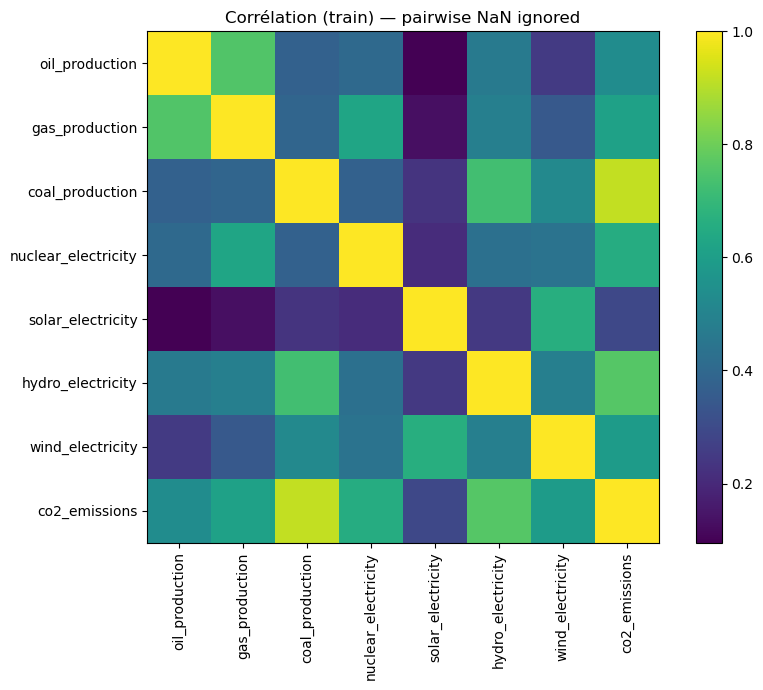

,oil_production,gas_production,coal_production,nuclear_electricity,solar_electricity,hydro_electricity,wind_electricity,co2_emissions
oil_production,1.000000,0.756102,0.375469,0.404968,0.095641,0.464429,0.250482,0.536797
gas_production,0.756102,1.000000,0.391608,0.626676,0.133796,0.485108,0.346478,0.614235
coal_production,0.375469,0.391608,1.000000,0.376545,0.232280,0.726350,0.522779,0.915537
nuclear_electricity,0.404968,0.626676,0.376545,1.000000,0.211646,0.429881,0.439229,0.654290
solar_electricity,0.095641,0.133796,0.232280,0.211646,1.000000,0.245338,0.663104,0.291267
hydro_electricity,0.464429,0.485108,0.726350,0.429881,0.245338,1.000000,0.485863,0.762528
wind_electricity,0.250482,0.346478,0.522779,0.439229,0.663104,0.485863,1.000000,0.591301
co2_emissions,0.536797,0.614235,0.915537,0.654290,0.291267,0.762528,0.591301,1.000000


In [ ]:
# matrice de corrélation des features

import matplotlib.pyplot as plt

corr = train[FEATURES + [TARGET]].corr(min_periods=200)

plt.figure(figsize=(9, 7))
plt.imshow(corr.values)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Corrélation (train) — pairwise NaN ignored")
plt.tight_layout()
plt.show()

corr


In [39]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

def eval_model(name, estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train)
    pred = estimator.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))  # compatible toutes versions
    r2 = r2_score(y_test, pred)

    return {"model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

# --- Baseline OLS ---
baseline = Pipeline([
    ("prep", preprocess),
    ("lr", LinearRegression())
])

# --- ElasticNet ---
enet = Pipeline([
    ("prep", preprocess),
    ("enet", ElasticNetCV(l1_ratio=[0.2,0.5,0.8,1.0], cv=5, random_state=42, max_iter=20000))
])

rows = []
rows.append(eval_model("Baseline (LinearRegression)", baseline, X_train, y_train, X_test, y_test))
rows.append(eval_model("ElasticNetCV", enet, X_train, y_train, X_test, y_test))

compare = pd.DataFrame(rows).set_index("model")
compare = compare[["MAE", "RMSE", "R2"]].round(3)

display(compare)


,MAE,RMSE,R2
model,,,
Baseline (LinearRegression),69.717000,233.989000,0.921000
ElasticNetCV,104.240000,204.850000,0.940000
